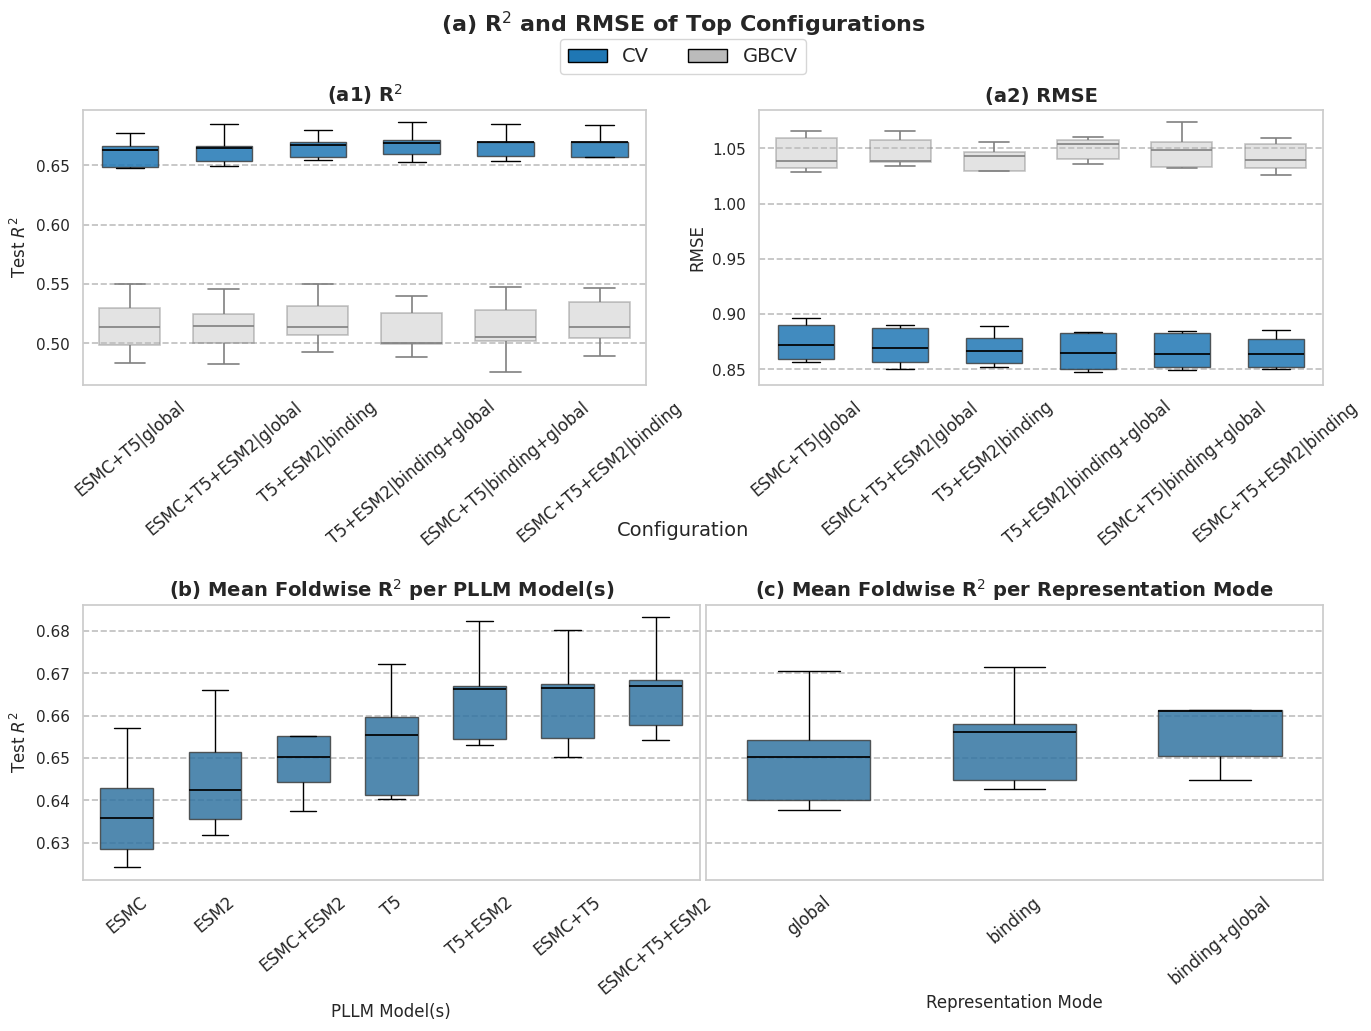

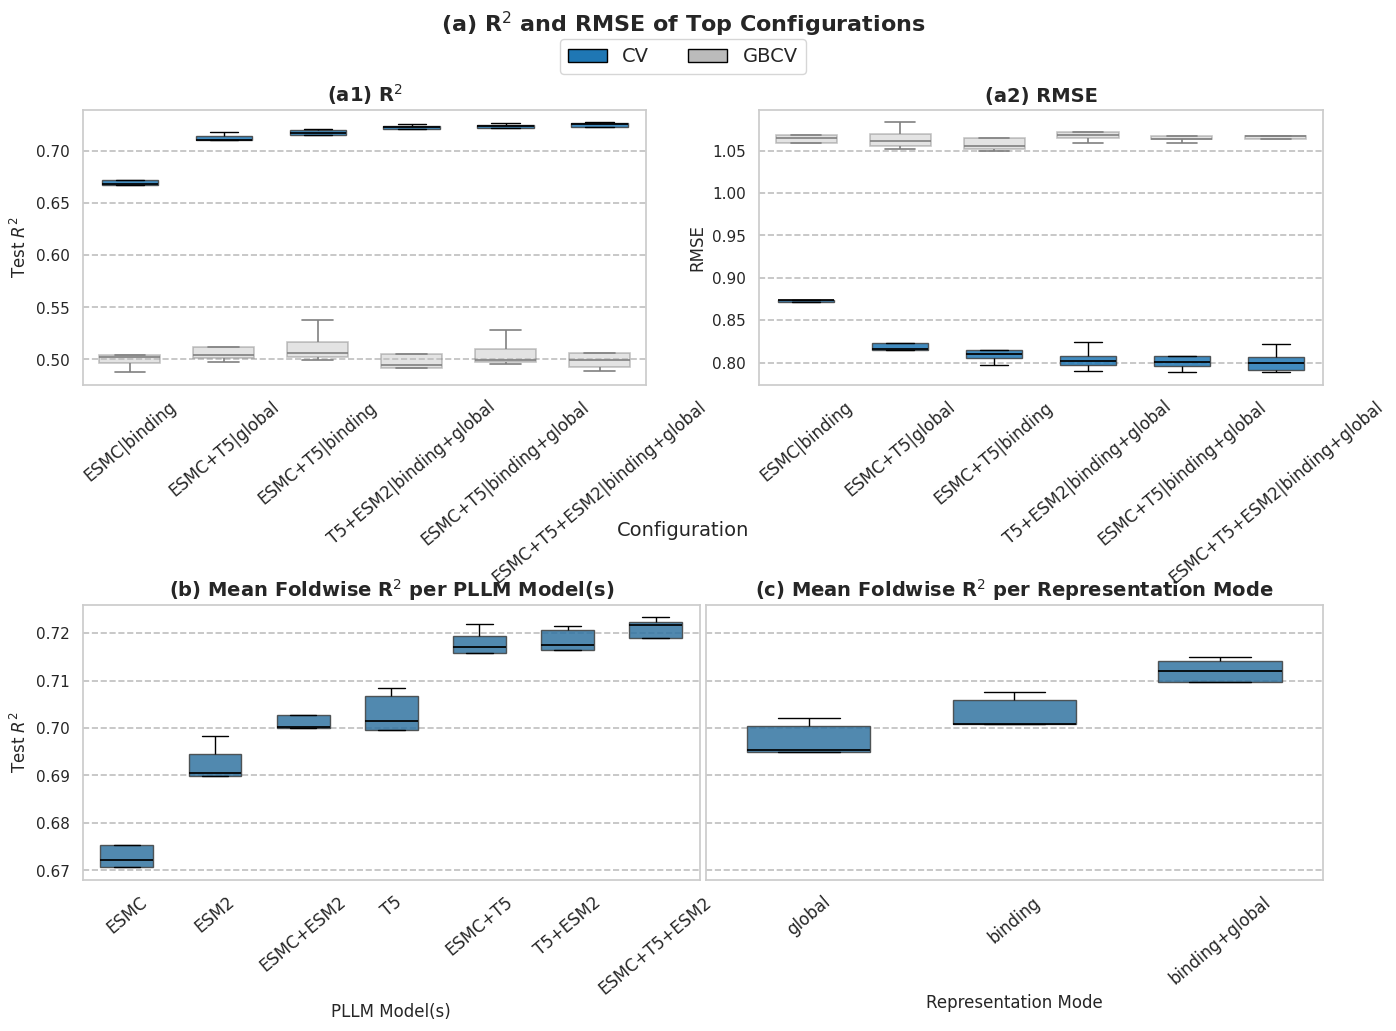

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from collections import defaultdict
from statistics import median, mean
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch

for dataset in ['dlkcat', 'eitlem']:
    # Reset rcParams
    mpl.rcParams.update(mpl.rcParamsDefault)

    # Load results
    results_path = f'/home/saleh/KinForm-1/results/prot_rep_gs_{dataset}.pkl'
    with open(results_path, 'rb') as f:
        all_results = pickle.load(f)

    # Flatten and organize metrics
    flat_results = [entry for results in all_results.values() for entry in results]
    df_metrics = pd.DataFrame(flat_results)

    # Compute medians
    group_gkf = df_metrics[df_metrics["split"] == "groupkfold"]
    plain_kf = df_metrics[df_metrics["split"] == "kfold"]
    median_r2_gkf = group_gkf.groupby("config")["r2"].median()
    median_r2_kf  = plain_kf.groupby("config")["r2"].median()

    N = 3
    topn_gkf = median_r2_gkf.sort_values(ascending=False).head(N).index.tolist()
    topn_kf  = median_r2_kf.sort_values(ascending=False).head(N).index.tolist()
    plot_configs   = list(dict.fromkeys(topn_gkf + topn_kf))
    sorted_configs = median_r2_kf.loc[plot_configs].sort_values().index.tolist()

    df_plot = df_metrics[df_metrics["config"].isin(sorted_configs)].copy()
    df_plot["config"] = pd.Categorical(df_plot["config"],
                                    categories=sorted_configs,
                                    ordered=True)

    # Summary‐level structures (unchanged)
    group_score_mode    = 'mean'
    summary_records     = []
    kfold_dict_combo    = defaultdict(lambda: defaultdict(list))
    kfold_dict_rep      = defaultdict(lambda: defaultdict(list))
    group_dict_combo    = defaultdict(lambda: defaultdict(list))
    group_dict_rep      = defaultdict(lambda: defaultdict(list))

    for config, entries in all_results.items():
        kfold_r2s = [e['r2'] for e in entries if e['split'] == 'kfold']
        if not kfold_r2s:
            continue
        median_r2 = median(kfold_r2s)
        model_combo, rep_mode = config.split('|')
        summary_records.append({
            'config': config,
            'model_combo': model_combo,
            'rep_mode': rep_mode,
            'median_r2': median_r2
        })

        for e in entries:
            if e['split'] == 'kfold':
                kfold_dict_combo[model_combo][e['fold']].append(e['r2'])
                kfold_dict_rep[rep_mode][e['fold']].append(e['r2'])
            elif e['split'] == 'groupkfold':
                group_dict_combo[model_combo][e['fold']].append(e['r2'])
                group_dict_rep[rep_mode][e['fold']].append(e['r2'])

    summary_df = pd.DataFrame(summary_records)

    def build_plot_df(grouping_col, split):
        src = {
            ('model_combo', 'kfold'): kfold_dict_combo,
            ('model_combo', 'groupkfold'): group_dict_combo,
            ('rep_mode',   'kfold'): kfold_dict_rep,
            ('rep_mode',   'groupkfold'): group_dict_rep
        }[(grouping_col, split)]
        
        data = []
        reducer = mean if group_score_mode == 'mean' else median

        if group_score_mode == 'max':
            best_cfgs = summary_df.loc[
                summary_df.groupby(grouping_col)['median_r2'].idxmax()
            ]
            for _, row in best_cfgs.iterrows():
                group = row[grouping_col]
                for e in all_results[row['config']]:
                    if e['split'] == split:
                        data.append({'group': group, 'r2': e['r2'], 'split': split})
        else:
            for group, fold_dict in src.items():
                if group not in summary_df[grouping_col].unique():
                    continue
                for fold, vals in fold_dict.items():
                    if vals:
                        data.append({'group': group, 'r2': reducer(vals), 'split': split})
        return pd.DataFrame(data)

    # Build grouped data
    df_combo = pd.concat([
        build_plot_df('model_combo', 'kfold'),
        build_plot_df('model_combo', 'groupkfold')
    ], ignore_index=True)

    df_rep = pd.concat([
        build_plot_df('rep_mode', 'kfold'),
        build_plot_df('rep_mode', 'groupkfold')
    ], ignore_index=True)

    combo_order = df_combo[df_combo['split'] == 'kfold']\
        .groupby('group')['r2'].median().sort_values().index.tolist()
    rep_order   = df_rep[df_rep['split'] == 'kfold']\
        .groupby('group')['r2'].median().sort_values().index.tolist()

    df_combo['group'] = pd.Categorical(df_combo['group'],
                                    categories=combo_order,
                                    ordered=True)
    df_rep['group']  = pd.Categorical(df_rep['group'],
                                    categories=rep_order,
                                    ordered=True)


    def plot_metrics(df_metrics, sorted_configs, axes, two_split_modes=False,
                        cv_color="#1f77b4", gbcv_color="#7f7f7f"):
        sns.set_theme(style="whitegrid", context="talk", rc={
            "axes.edgecolor": "black",
            "axes.linewidth": 1.0,
            "axes.labelsize": 12,
            "axes.labelweight": "regular",
            "xtick.labelsize": 10,
            "ytick.labelsize": 10,
            "xtick.direction": "out",
            "ytick.direction": "out",
            "grid.color": "#eaeaf2",
            "grid.linestyle": "--",
            "grid.linewidth": 0.8,
            "legend.frameon": False,
            "legend.fontsize": 10,
            "figure.dpi": 150,
            "savefig.dpi": 300,
            "font.family": "sans-serif",
            "font.sans-serif": ["Helvetica", "DejaVu Sans", "Arial"],
        })
    
        for ax, metric in zip(axes, ["r2", "rmse"]):
            if two_split_modes:
                df_group = df_metrics[df_metrics["split"] == "groupkfold"]
                df_kfold = df_metrics[df_metrics["split"] == "kfold"]
                sns.boxplot(
                    x="config", y=metric, data=df_kfold, ax=ax,
                    color=cv_color,        # <-- force a single facecolor
                    width=0.6, showfliers=False,
                    boxprops=dict(alpha=0.85, facecolor=cv_color),
                    medianprops=dict(color='black', linewidth=1.25),
                    whiskerprops=dict(color='black'),
                    capprops=dict(color='black')
                )
                sns.boxplot(
                    x="config", y=metric, data=df_group, ax=ax,
                    color=gbcv_color,       # <-- force single grey facecolor
                    width=0.65, linewidth=1.2, showfliers=False,
                    boxprops=dict(alpha=0.4, facecolor=gbcv_color),
                    medianprops=dict(color='gray'),
                    whiskerprops=dict(color='gray'),
                    capprops=dict(color='gray')
                )
            else:
                sns.boxplot(
                    x="config", y=metric, data=df_kfold, ax=ax,
                    color=cv_color,        # <-- force a single facecolor
                    width=0.6, showfliers=False,
                    boxprops=dict(alpha=0.85, facecolor=cv_color),
                    medianprops=dict(color='black', linewidth=1.25),
                    whiskerprops=dict(color='black'),
                    capprops=dict(color='black')
                )

            # No per‐axis x‐label here; we’ll add a single shared one below.
            ax.set_xlabel("")
            ax.set_ylabel(r"Test $R^2$" if metric == "r2" else r"RMSE")
            ax.tick_params(axis='x', rotation=40)
            ax.grid(axis='y', linestyle='--', linewidth=1.2, color='gray', alpha=0.5)
            ax.grid(axis='x', visible=False)


    # ----- Plot all in one figure, with nested GridSpec -----
    sns.set_theme(style="whitegrid")

    fig = plt.figure(figsize=(16, 10))

    # 1) Create an outer 2×1 GridSpec
    outer_gs = GridSpec(2, 1, figure=fig, height_ratios=[1, 1], hspace=0.8)

    # 2) Top row = subgridspec with 1×2, normal wspace (e.g. 0.25)
    top_gs = outer_gs[0].subgridspec(1, 2, wspace=0.2)

    # 3) Bottom row = subgridspec with 1×2, small wspace (e.g. 0.02)
    bot_gs = outer_gs[1].subgridspec(1, 2, wspace=0.01)

    # — Create axes —
    ax_top_left  = fig.add_subplot(top_gs[0, 0])
    ax_top_right = fig.add_subplot(top_gs[0, 1], sharex=ax_top_left)

    ax_bot_left  = fig.add_subplot(bot_gs[0, 0])
    ax_bot_right = fig.add_subplot(bot_gs[0, 1], sharey=ax_bot_left)
    cv_color = "#1f77b4"    
    gbcv_color = "#BBBBBB" 
    # 4) Figure‐level title
    fig.suptitle(
        r"(a) $\mathbf{R}^2$ and RMSE of Top Configurations", 
        fontsize=16, fontweight='bold', 
        x=0.5, y=0.98
    )
    legend_handles = [
        Patch(facecolor=cv_color,   edgecolor="black", label="CV"),
        Patch(facecolor=gbcv_color, edgecolor="black", label="GBCV")
    ]
    fig.legend(
        handles=legend_handles,
        loc='upper center',
        bbox_to_anchor=(0.5, 0.96),
        ncol=2,
        frameon=True,
        fontsize=14
    )
    # 5) Plot the top two (a1 and a2) without their own x‐labels
    plot_metrics(
        df_plot,
        sorted_configs=sorted_configs,
        axes=[ax_top_left, ax_top_right],
        two_split_modes=True,
        cv_color=cv_color,
        gbcv_color=gbcv_color
    )
    ax_top_left.set_title(r"(a1) $\mathbf{R}^2$", fontsize=14, fontweight='bold')
    ax_top_right.set_title(r"(a2) RMSE", fontsize=14, fontweight='bold')

    # 6) Add one shared “Configuration” xlabel, positioned just below the top row
    #    The figure’s coordinate y=0.45 is roughly midway between row‐1 and row‐2,
    #    but you can tweak 0.45 up/down if needed.
    fig.supxlabel(
        "Configuration", 
        fontsize=14, 
        fontweight='regular', 
        x=0.5, 
        y=0.45
    )

    # 7) Bottom‐left: Mean Foldwise R² per PLLM Model(s)
    sns.boxplot(
        data=df_combo[df_combo['split'] == 'kfold'],
        x='group', y='r2', ax=ax_bot_left,
        color=cv_color, width=0.6, showfliers=False,
        boxprops=dict(alpha=0.85),
        medianprops=dict(color='black', linewidth=1.25),
        whiskerprops=dict(color='black'),
        capprops=dict(color='black')
    )
    ax_bot_left.set_title(
        r"(b) Mean Foldwise $\mathbf{R}^2$ per PLLM Model(s)", 
        fontsize=14, fontweight='bold'
    )
    ax_bot_left.set_xlabel('PLLM Model(s)')
    ax_bot_left.set_ylabel(r"Test $R^2$")
    ax_bot_left.tick_params(axis='x', rotation=40)
    ax_bot_left.grid(axis='y', linestyle='--', linewidth=1.2, color='gray', alpha=0.5)
    ax_bot_left.grid(axis='x', visible=False)

    # 8) Bottom‐right: Mean Foldwise R² per Representation Mode
    sns.boxplot(
        data=df_rep[df_rep['split'] == 'kfold'],
        x='group', y='r2', ax=ax_bot_right,
        color=cv_color, width=0.6, showfliers=False,
        boxprops=dict(alpha=0.85),
        medianprops=dict(color='black', linewidth=1.25),
        whiskerprops=dict(color='black'),
        capprops=dict(color='black')
    )
    ax_bot_right.set_title(
        r"(c) Mean Foldwise $\mathbf{R}^2$ per Representation Mode", 
        fontsize=14, fontweight='bold'
    )
    ax_bot_right.set_xlabel('Representation Mode')
    ax_bot_right.set_ylabel("")  # no redundant ylabel
    ax_bot_right.tick_params(axis='x', rotation=40)
    ax_bot_right.grid(axis='y', linestyle='--', linewidth=1.2, color='gray', alpha=0.5)
    ax_bot_right.grid(axis='x', visible=False)

    # 9) Share y‐axis on bottom row
    ax_bot_right.set_ylim(ax_bot_left.get_ylim())
    ax_bot_right.tick_params(labelleft=False)
    for ax in [ax_bot_left, ax_bot_right, ax_top_left, ax_top_right]:
        ax.tick_params(axis='x', labelsize=12)   
    # 10) Save & show
    fig.savefig(
        f'/home/saleh/KinForm-1/results/plots/{dataset}_gridsearch_summary.png',
        bbox_inches="tight", dpi=600
    )
    plt.show()

In [ ]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import numpy as np

# Style settings
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'axes.linewidth': 1.2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'grid.alpha': 0.3,
    'grid.linewidth': 0.8,
    'figure.facecolor': 'white'
})

# Mapping for display names
name_map = {
    'UniMol': 'UniMol2',
    'FARM': 'FARM',
    'MFP': 'MFP',
    'molformer': 'MolFormer',
    'smiles_transformer': 'SMILES Transformer',
}

combined_dfs = []

for task_config in ['kcat', 'km']:
    all_results_path = f"/home/saleh/KinForm-1/results/smiles_rep_gs_{task_config}.pkl"
    with open(all_results_path, 'rb') as f:
        all_results = pickle.load(f)

    flat_results = [r | {"config": cfg} for cfg, res_list in all_results.items() for r in res_list]
    df = pd.DataFrame(flat_results)

    suffix = "|PCA (ESMC+ESM2+T5, k=300)" if task_config == 'kcat' else "|ESMC(both)"
    df = df[df["config"].str.endswith(suffix)].copy()
    df["short_config"] = df["config"].str.replace(suffix, "", regex=False)
    df["short_config"] = df["short_config"].map(name_map)
    df["task"] = "kcat" if task_config == "kcat" else "km"
    combined_dfs.append(df)

# Combine and clean
df_combined = pd.concat(combined_dfs, axis=0)
df_combined = df_combined[df_combined["short_config"].notnull()]

# Sort SMILES methods by mean of median R² across tasks and splits
smiles_order = (
    df_combined
    .groupby("short_config")["r2"]
    .median()
    .groupby(level=0)
    .mean()
    .sort_values()
    .index.tolist()
)

df_combined["short_config"] = pd.Categorical(df_combined["short_config"], categories=smiles_order, ordered=True)
df_combined["task"] = df_combined["task"].map({"kcat": "$k_{cat}$", "km": "$K_M$"})

# Plot setup
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=False)

palette = sns.color_palette("Set2")
split_styles = {
    "kfold": dict(linestyle='solid', alpha=0.9),
    "groupkfold": dict(linestyle='dashed', alpha=0.6),
}

for ax, task in zip(axes, ["$k_{cat}$", "$K_M$"]):
    task_df = df_combined[df_combined["task"] == task]

    for split, style in split_styles.items():
        sns.boxplot(
            data=task_df[task_df["split"] == split],
            x="short_config", y="r2",
            palette=palette, width=0.6, dodge=False, ax=ax,
            showcaps=True,
            boxprops=dict(linewidth=1.5, linestyle=style['linestyle'], alpha=style['alpha']),
            whiskerprops=dict(linewidth=1.5, linestyle=style['linestyle']),
            capprops=dict(linewidth=1.5, linestyle=style['linestyle']),
            medianprops=dict(color='black', linewidth=1),
            flierprops=dict(marker='o', alpha=0.2),
        )

    ax.set_title(task, fontsize=15, fontweight='bold', pad=10)
    ax.tick_params(axis='x', labelsize=11, rotation=30)
    ax.grid(axis='y', linestyle='--', linewidth=0.8, color='gray', alpha=0.6)
    #  remove x-axis label 
    ax.set_xlabel("")

# Shared y-axis label
axes[0].set_ylabel("Test $\mathbf{R}^2$", fontsize=14, fontweight='bold')
axes[1].set_ylabel("")

# Custom Legend
style_handles = [
    Line2D([0], [0], color='black', linewidth=1.5, linestyle='solid', label='CV'),
    Line2D([0], [0], color='black', linewidth=1.5, linestyle='dashed', label='GBCV'),
]
fig.legend(
    handles=style_handles,
    loc='upper center', bbox_to_anchor=(0.5, 1),
    fontsize=13, ncol=2, frameon=True
)

fig.supxlabel("SMILES Representation Method", fontsize=15, fontweight='bold')
# Main title
fig.suptitle("Comparison of SMILES Representation Methods", fontsize=17, fontweight='bold', y=1.03)

plt.tight_layout(rect=[0, 0, 1, 1.05])
output_path = "/home/saleh/KinForm-1/results/plots/smiles_comparison.png"
plt.savefig(output_path, dpi=600, bbox_inches='tight', facecolor='white')
plt.show()


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
# ── 1.  Put this near the top of the file, after the imports ──────────
from matplotlib.legend_handler import HandlerBase
from matplotlib.patches import Rectangle
import numpy as np
import matplotlib as mpl

class _HandlerGradient(HandlerBase):
    """Custom legend handler that draws a blue→yellow gradient patch with a black stroke."""
    def __init__(self, cmap):
        super().__init__()
        self.cmap = cmap

    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height,
                       fontsize, trans):
        n = 128
        xs = np.linspace(xdescent, xdescent + width, n + 1)
        patches = []

        offset = 0.45 * height
        y0 = ydescent - offset
        box_height = height
        box_width = xs[-1] - xs[0]

        # 1. Add a black border rectangle first
        border = Rectangle(
            (xdescent, y0),
            box_width,
            box_height,
            transform=trans,
            facecolor='none',
            edgecolor='black',
            linewidth=2.0
        )
        patches.append(border)

        # 2. Add gradient strips on top
        for i in range(n):
            frac = i / (n - 1)
            color = self.cmap(frac)
            r = Rectangle(
                (xs[i], y0),
                xs[i + 1] - xs[i],
                box_height,
                transform=trans,
                facecolor=color,
                edgecolor=color,
                linewidth=0
            )
            patches.append(r)

        return patches


def plot_metrics_pca(df_metrics: pd.DataFrame,
                     output_path: str,
                     *,
                     sorted_configs,
                     two_split_modes: bool = False):
    """
    Draw boxplots of R² and RMSE across folds, comparing two base models
    (ESMC+1v+T5 vs ESMC+T5) via line style, and PCA component counts via color.
    
    Parameters
    ----------
    df_metrics : DataFrame
        Must contain columns ['config','split','n_comps','r2','rmse'].
    output_path : str
        Path to save the figure (PNG).
    sorted_configs : list of str
        Ordering of configs to include (from your group-kfold median ranking).
    two_split_modes : bool
        If True, overlays k-fold in grey behind groupkfold colors.
    """
    # 1) Filter to just the configs of interest and order them
    df = df_metrics[df_metrics['config'].isin(sorted_configs)].copy()
    
    # 2) Extract model name and safe PCA label
    df['model'] = df['config'].str.split('|').str[0]
    df['pca'] = df['n_comps'].apply(lambda x: 'No PCA' if pd.isna(x) else str(int(x)))

    # 3) Define orders
    model_order = ['ESMC+ESM2+T5', 'ESMC+T5']
    pca_levels = ['No PCA'] + sorted(
        [lvl for lvl in df['pca'].unique() if lvl != 'No PCA'],
        key=lambda z: int(z)
    )

    # 4) Color palette for PCA levels
    palette = dict(zip(
        pca_levels,
        sns.color_palette("viridis", len(pca_levels))
    ))
    # Line styles for models
    style_map = {k: v for k, v in zip(model_order, ['-', '--'])}
    
    metric = 'r2' 
    fig, ax = plt.subplots(figsize=(18, 8))
    ax.margins(x=0.2)  
    gap = 0.3
    width = 1
    for model in model_order:
        sub = df[df['model']==model]
 
        if two_split_modes:
            gkf = sub[sub['split']=='groupkfold']
            kf = sub[sub['split']=='kfold']
            sns.boxplot(
                x='model', y=metric, hue='pca', data=gkf,
                order=model_order, hue_order=pca_levels,
                ax=ax, palette=palette, width=width,
                boxprops={'linestyle': style_map[model], 'alpha':0.85},
                showfliers=False, gap = gap, linewidth=1.2,
            )

            sns.boxplot(
                x='model', y=metric, hue='pca', data=kf,
                order=model_order, hue_order=pca_levels,
                ax=ax, palette=['#BBBBBB']*len(pca_levels),
                width=width, linewidth=1.2,
                boxprops={'linestyle': style_map[model], 'alpha':0.4},
                showfliers=False,
                whiskerprops={'color':'gray'},
                capprops={'color':'gray'},
                medianprops={'color':'gray'},
                flierprops={'markerfacecolor':'gray','markeredgecolor':'gray'},
                gap = gap,
            )
        else:
            # single-hue boxplot
            sns.boxplot(
                x='model', y=metric, hue='pca', data=sub,
                order=model_order, hue_order=pca_levels,
                ax=ax, palette=palette, width=0.6,
                boxprops={'linestyle': style_map[model], 'alpha':0.85},
                showfliers=False
            )
        
        # Build legend: PCA color patches + model line samples
        pca_handles = [Patch(facecolor=palette[p], edgecolor='black', label=p) for p in pca_levels]
        sns.set_theme(style="whitegrid", font_scale=1.2)
        # 1) Set theme and gridlines
        ax.grid(axis='y', linestyle='--', linewidth=1.5, color='gray', alpha=0.7)
        ax.grid(axis='x', visible=False)
        ax.set_xlabel("Embedding Models Combination", fontsize=17, weight='bold')
        ylabel = r"Test $\mathbf{R}^2$" if metric == 'r2' else "RMSE"
        ax.set_ylabel(ylabel, fontsize=17, weight='bold')
        ax.tick_params(axis='x', rotation=0, labelsize=14)
        ax.tick_params(axis='y', labelsize=14)

        # 3) Replace legend block with cleaner version (outside loop)
        if ax.get_legend() is not None:
            ax.get_legend().remove()

        pca_handles = [Patch(facecolor=palette[p], edgecolor='black', label=p) for p in pca_levels]

        legend_pca = fig.legend(
            handles=pca_handles,
            title="PCA components",
            loc="upper center",
            bbox_to_anchor=(0.5, 1.05),
            ncol=len(pca_handles),
            frameon=True,
            handleheight=1.5,
            columnspacing=1.6,
            borderpad=0.6,
            fontsize=15,
            title_fontsize=14,
        )
        ax.add_artist(legend_pca)  

        cv_handle    = Patch(facecolor='#BBBBBB', edgecolor='black')
        gcbv_proxy   = Rectangle((0, 0), 1, 1, edgecolor='black')
        cmap         = mpl.cm.get_cmap('viridis') 

        legend_split = fig.legend(
            handles=[cv_handle, gcbv_proxy],
            labels=["CV", "GBCV"],
            handler_map={gcbv_proxy: _HandlerGradient(cmap)},
            loc="upper center",
            bbox_to_anchor=(0.5, 0.94),   # slightly below the PCA legend
            frameon=True,                # no extra frame; sits inside the first
            ncol=2,
            handleheight=1.5,
            columnspacing=1.6,
            borderpad=0.3,
            fontsize=15,
            title="Split Type",           # optional subtitle
            title_fontsize=14,
        )

    # → add your separator line here:
    ax.axvline(x=0.5, linestyle='--', color='gray', linewidth=1.5, alpha=0.7)
    fig.suptitle(
        "Model Performance With PCA-Reduced Protein Features",
        fontsize=18, fontweight='bold', y=1.07
    )       

    fig.tight_layout(rect=[0, 0, 1, 0.92])  # leave space for titl

    fig.savefig(output_path, bbox_inches="tight", dpi=600)
    
    plt.show()


/tmp/ipykernel_3722310/1520673170.py:179: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap         = mpl.cm.get_cmap('viridis')
/tmp/ipykernel_3722310/1520673170.py:179: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap         = mpl.cm.get_cmap('viridis')


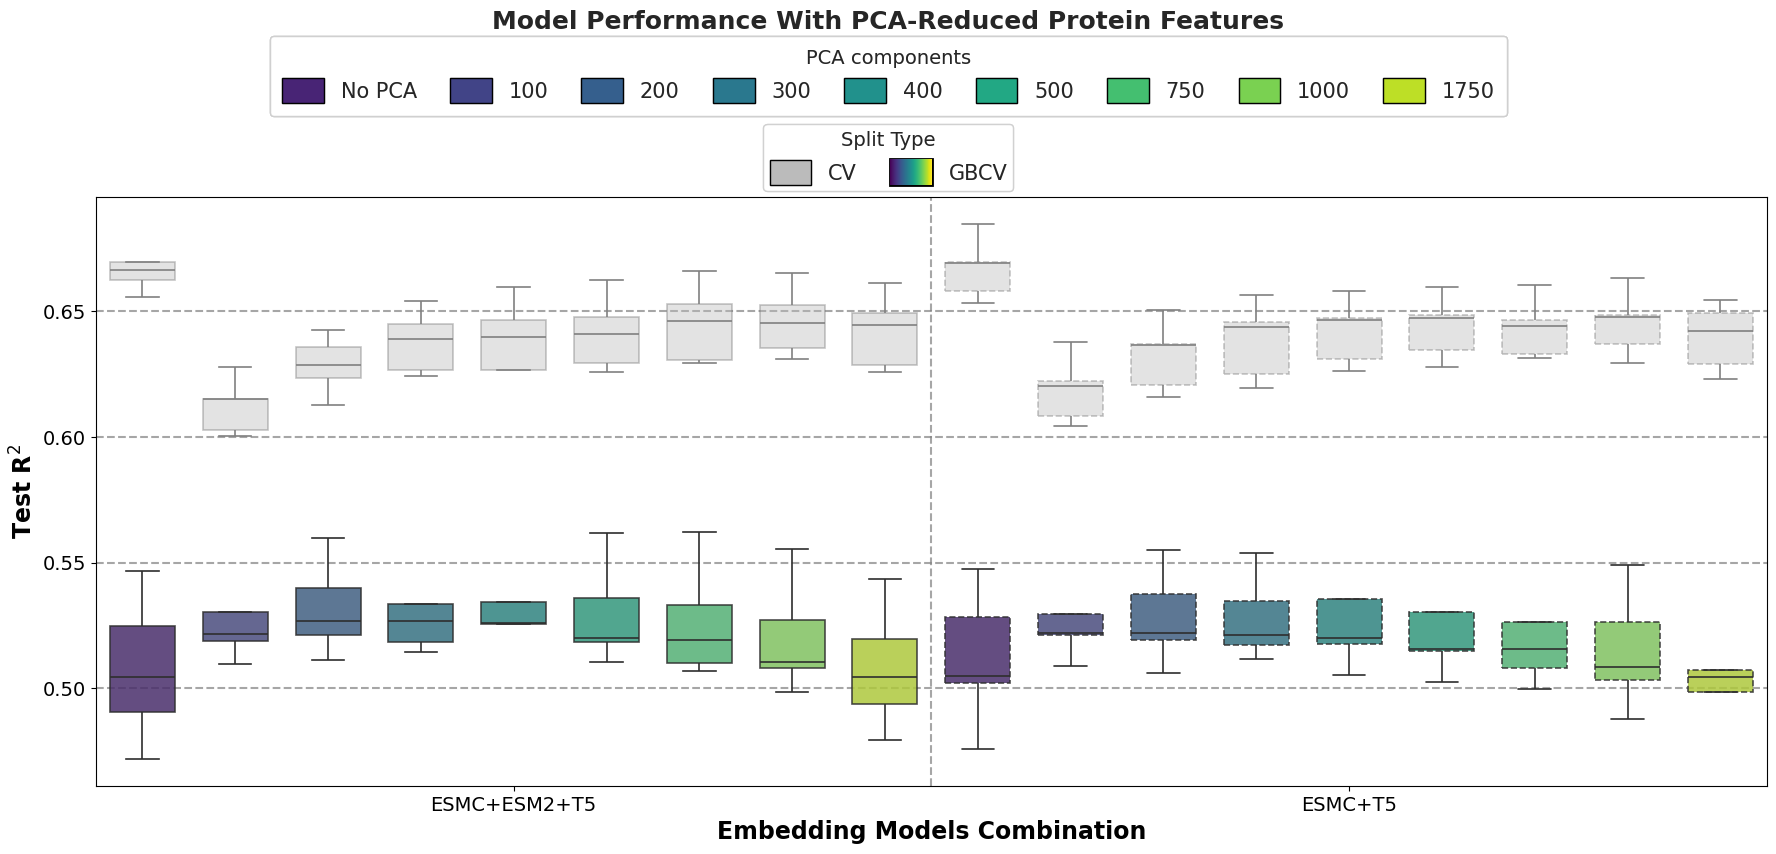

/tmp/ipykernel_3722310/1520673170.py:179: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap         = mpl.cm.get_cmap('viridis')
/tmp/ipykernel_3722310/1520673170.py:179: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap         = mpl.cm.get_cmap('viridis')


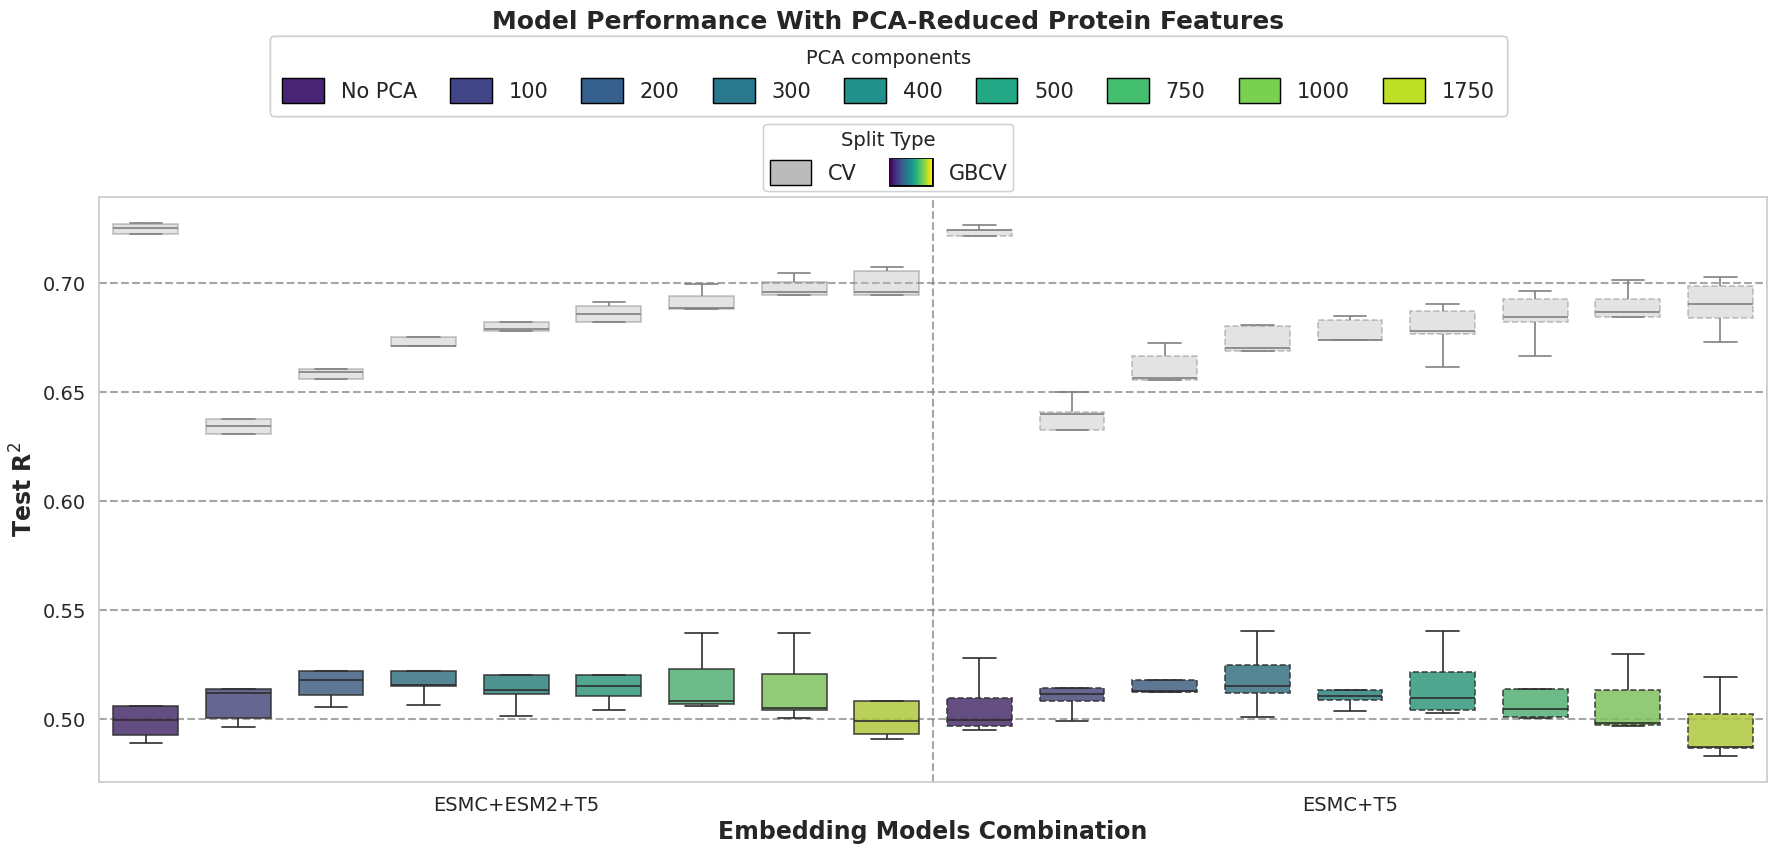

In [3]:
# PCA grid search results 
for dataset in ['dlkcat', 'eitlem']:
    import pickle
    import pandas as pd
    results_path = f'/home/saleh/KinForm-1/results/pca_gs_{dataset}.pkl'
    with open(results_path, 'rb') as f:
        all_results = pickle.load(f)

    # Save all results in flat form
    flat_results = [entry for results in all_results.values() for entry in results]

    df = pd.DataFrame(flat_results)
    group_median = df[df["split"] == "groupkfold"].groupby("config")["r2"].median()
    sorted_configs = group_median.sort_values().index.tolist()
    plot_metrics_pca(
        df,                                      # same DataFrame as before
        f"/home/saleh/KinForm-1/results/plots/pca_gs_{dataset}.png",
        sorted_configs=sorted_configs,
        two_split_modes=True,                    # keeps coloured (GKF) + grey (KF)
    )

In [3]:
#!/usr/bin/env python3
"""
plot_ae_gs.py ― visualise the Auto-encoder grid-search results
==============================================================

• Reads utils/autoencoder-based CV output (`ae_gs_*.pkl`)
• Produces publication-ready box-plots (k-fold in grey, group-k-fold in colour)
• One protein representation only   →   a single row of boxes per figure

Run:
    $ python plot_ae_gs.py
"""

# ──────────────────────────────────────────────────────────────────────────────
# Imports & utilities
# ──────────────────────────────────────────────────────────────────────────────
import pickle
from pathlib import Path
from typing import List

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch, Rectangle
from matplotlib.legend_handler import HandlerBase
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme(style="whitegrid", font_scale=1.2)

# --------------------------------------------------------------------------- #
# Gradient-legend helper (identical to the PCA script)                        #
# --------------------------------------------------------------------------- #
class _HandlerGradient(HandlerBase):
    """Legend handler that draws a blue→yellow gradient patch + black stroke."""
    def __init__(self, cmap):
        super().__init__()
        self.cmap = cmap

    def create_artists(
        self, legend, orig_handle,
        xdescent, ydescent, width, height,
        fontsize, trans
    ):
        n = 128
        xs = np.linspace(xdescent, xdescent + width, n + 1)
        patches = []

        offset = 0.45 * height
        y0 = ydescent - offset
        box_height = height
        box_width  = xs[-1] - xs[0]

        # black border
        border = Rectangle(
            (xdescent, y0),
            box_width, box_height,
            transform=trans,
            facecolor='none',
            edgecolor='black',
            linewidth=2.0
        )
        patches.append(border)

        # gradient strips
        for i in range(n):
            frac  = i / (n - 1)
            color = self.cmap(frac)
            r = Rectangle(
                (xs[i], y0),
                xs[i + 1] - xs[i],
                box_height,
                transform=trans,
                facecolor=color, edgecolor=color, linewidth=0
            )
            patches.append(r)

        return patches


# ──────────────────────────────────────────────────────────────────────────────
# Plotting
# ──────────────────────────────────────────────────────────────────────────────
def plot_metrics_ae(
    df_metrics: pd.DataFrame,
    output_path: str,
    *,
    sorted_configs: List[str],
    two_split_modes: bool = True
):
    """
    Draw box-plots of R² across folds for auto-encoder latent-dims.

    Parameters
    ----------
    df_metrics : DataFrame
        Must have columns ['config','split','latent_dim','r2'].
    output_path : str
        Where to save the PNG.
    sorted_configs : list
        Desired ordering of configs (taken from group-kfold median ranking).
    two_split_modes : bool
        If True, overlays k-fold results in grey behind the coloured group-kfold.
    """
    # A) keep only chosen configs, set order
    df = df_metrics[df_metrics["config"].isin(sorted_configs)].copy()

    # B) extract *single* model name (everything before first '_AE')
    df["model"] = df["config"].str.replace(r"_(AE\d+|noAE)$", "", regex=True)

    df["ae_dim"] = df["latent_dim"].apply(lambda x: "No AE" if pd.isna(x) else str(int(x)))

    model_order = ["ESMC+ESM2+T5"]                # ← only one row
    ae_levels = sorted(df["ae_dim"].unique(), key=lambda x: float('inf') if x == "No AE" else int(x))

    # colour palette (viridis)
    palette = dict(zip(ae_levels, sns.color_palette("viridis", len(ae_levels))))
    style_map = {model_order[0]: "-"}             # solid boxes

    metric = "r2"
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.margins(x=0.2)
    gap   = 0.3
    width = 0.7

    for model in model_order:
        sub = df[df["model"] == model]
        gk = sub[sub["split"] == "groupkfold"]
        kf = sub[sub["split"] == "kfold"]
        x_order = ae_levels
        sns.boxplot(
            x="ae_dim", y=metric, data=gk,
            order=x_order,
            ax=ax, palette=palette,
            width=width,
            boxprops={"alpha": 0.85},
            linewidth=1.2, showfliers=False
        )

        # draw kfold in grey
        sns.boxplot(
            x="ae_dim", y=metric, data=kf,
            order=x_order,
            ax=ax, palette=["#BBBBBB"] * len(ae_levels),
            width=width,
            linewidth=1.2, showfliers=False,
            whiskerprops={"color": "gray"},
            capprops={"color": "gray"},
            medianprops={"color": "gray"},
            flierprops={"markerfacecolor": "gray", "markeredgecolor": "gray"},
            boxprops={"alpha": 0.4},
        )
    # grid & labels
    ax.grid(axis='y', linestyle='--', linewidth=1.5, color='gray', alpha=0.7)
    ax.grid(axis='x', visible=False)
    ax.set_xlabel("Embedding Model Combination", fontsize=16, weight="bold")
    ax.set_ylabel(r"Test $\mathbf{R}^2$", fontsize=16, weight="bold")
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    # (1) latent-dim legend
    ae_handles = [Patch(facecolor=palette[d], edgecolor='black', label=d)
                  for d in ae_levels]
    legend_dim = fig.legend(
        handles=ae_handles,
        title="AE latent dim",
        loc="upper center",
        bbox_to_anchor=(0.5, 1.05),
        ncol=len(ae_handles),
        frameon=True,
        handleheight=1.5, columnspacing=1.6,
        borderpad=0.6, fontsize=14, title_fontsize=13,
    )
    ax.add_artist(legend_dim)

    # (2) split-type legend (colour vs grey gradient)
    cv_patch     = Patch(facecolor="#BBBBBB", edgecolor="black")
    gcv_proxy    = Rectangle((0, 0), 1, 1, edgecolor="black")
    cmap         = mpl.cm.get_cmap("viridis")

    legend_split = fig.legend(
        handles=[cv_patch, gcv_proxy],
        labels=["CV", "GroupCV"],
        handler_map={gcv_proxy: _HandlerGradient(cmap)},
        loc="upper center",
        bbox_to_anchor=(0.5, 0.94),
        ncol=2,
        frameon=True,
        handleheight=1.5, columnspacing=1.6,
        borderpad=0.3, fontsize=14, title="Split Type", title_fontsize=13,
    )

    fig.suptitle(
        "Model Performance With AE-Reduced Protein Features",
        fontsize=18, fontweight="bold", y=1.07
    )

    fig.tight_layout(rect=[0, 0, 1, 0.92])
    Path(output_path).parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(output_path, bbox_inches="tight", dpi=600)
    plt.show()

/tmp/ipykernel_1271809/2700623406.py:132: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_1271809/2700623406.py:142: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipykernel_1271809/2700623406.py:180: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap         = mpl.cm.get_cmap("viridis")


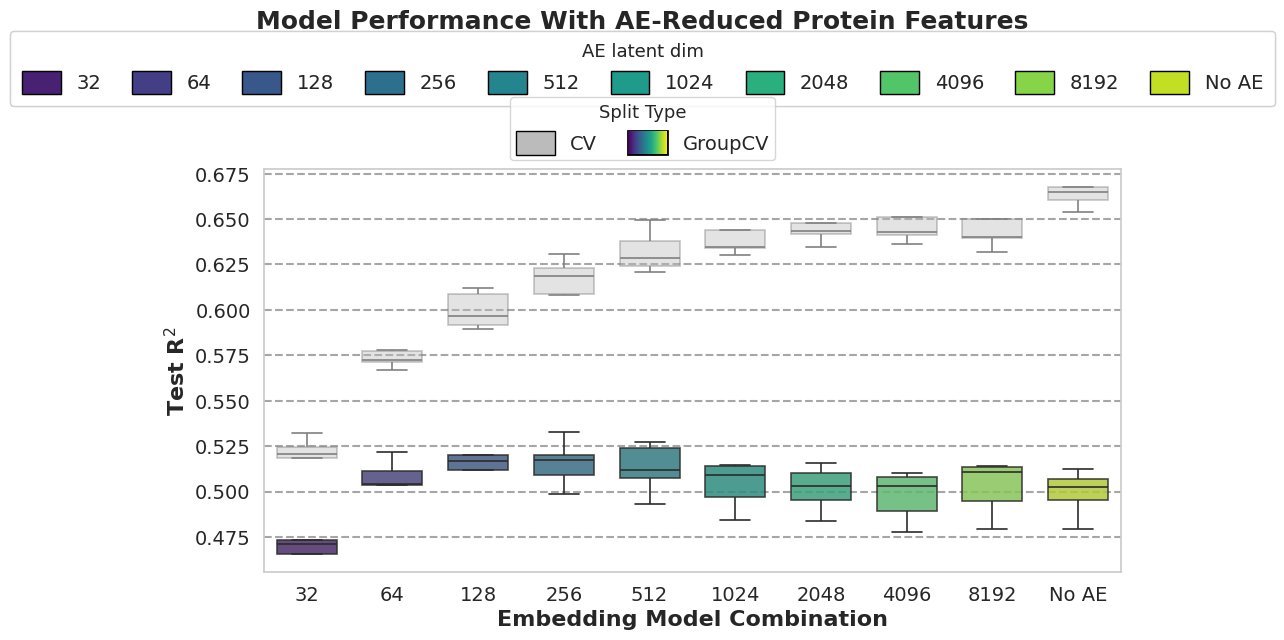

In [5]:

results_root = Path("/home/saleh/KinForm-1/results")
plot_dir     = results_root / "plots"

for dataset in ["dlkcat"]:
    pkl_path = results_root / f"ae_gs_{dataset}.pkl"

    with open(pkl_path, "rb") as fp:
        all_results = pickle.load(fp)

    # flatten → DataFrame
    flat = [entry for lst in all_results.values() for entry in lst]
    df   = pd.DataFrame(flat)

    # order configs by **median group-kfold R²** (ascending)
    med   = df[df["split"] == "groupkfold"].groupby("config")["r2"].median()
    order = med.sort_values().index.tolist()

    plot_metrics_ae(
        df,
        output_path=str(plot_dir / f"ae_gs_{dataset}.png"),
        sorted_configs=order,
        two_split_modes=True,
    )


In [ ]:
import pickle
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

def plot_layerwise_r2(results, output_path):
    # Prepare DataFrame
    df = pd.DataFrame(results)
    df['Task'] = df['task'].str.upper()
    df['Layer'] = df['layer'].astype(int)
    df['Model'] = df['model'].map({'esmc': 'ESMC', 'esm2': 'ESM-2', 'prot_t5': 'ProtT5'})
    
    # Style settings - clean academic paper style
    plt.style.use('seaborn-v0_8-white')  # Clean white background
    
    # Unified font settings
    base_fontsize = 12
    plt.rcParams.update({
        'font.size': base_fontsize,
        'axes.labelsize': base_fontsize + 1,      # 13 for axis labels
        'axes.titlesize': base_fontsize + 2,      # 14 for titles
        'xtick.labelsize': base_fontsize - 1,     # 11 for tick labels
        'ytick.labelsize': base_fontsize - 1,     # 11 for tick labels
        'legend.fontsize': base_fontsize,
        'font.family': 'sans-serif',
        'font.sans-serif': ['Helvetica', 'Arial', 'DejaVu Sans'],  # Helvetica for academic look
        'axes.linewidth': 1.0,
        'axes.edgecolor': '#000000',
        'axes.labelcolor': '#000000',
        'text.color': '#000000',
        'xtick.color': '#000000',
        'ytick.color': '#000000',
        'xtick.major.size': 4,
        'ytick.major.size': 4,
        'xtick.major.width': 0.8,
        'ytick.major.width': 0.8,
    })
    
    models = ['ESMC', 'ESM-2', 'ProtT5']
    tasks = ['KCAT', 'KM']
    
    # Layout parameters
    fig_width, fig_height = 8.5, 5.5
    left_margin = 0.12
    right_margin = 0.88
    bottom_margin = 0.10
    top_margin = 0.8
    plot_width = right_margin - left_margin
    plot_height = top_margin - bottom_margin

    # Spacing parameters
    row_spacing = 0.18
    col_spacing = 0.02  
    cbar_height = 0.01  
    cbar_bottom = 0.88
    cbar_top = cbar_bottom + cbar_height

    # Create figure
    fig = plt.figure(figsize=(fig_width, fig_height))

    # Create main grid
    gs_main = gridspec.GridSpec(3, 2, figure=fig, 
                                height_ratios=[1, 1, 1],
                                width_ratios=[1, 1],
                                hspace=row_spacing, wspace=col_spacing,
                                left=left_margin, right=right_margin, 
                                top=top_margin, bottom=bottom_margin) 

    gs_cb = gridspec.GridSpec(1, 2, figure=fig,
                            left=left_margin, right=right_margin,
                            top=cbar_top, bottom=cbar_bottom,
                            wspace=col_spacing)

    # Use a professional colormap
    cmap = plt.cm.RdBu_r  # Standard for diverging data
    
    # Compute individual norms for each task
    norms = {
        task: Normalize(
            vmin=df[df.Task == task].r2.min(),
            vmax=df[df.Task == task].r2.max()
        )
        for task in tasks
    }
    
    # Store axes for adding labels later
    axes = []
    global_r2_min = df['r2'].min()
    global_r2_max = df['r2'].max()
    # Plot boxplots per model and task
    for i, model in enumerate(models):
        row_axes = []
        for j, task in enumerate(tasks):
            ax = fig.add_subplot(gs_main[i, j])
            row_axes.append(ax)
            
            sub = df[(df.Model == model) & (df.Task == task)]
            layers = sorted(sub.Layer.unique())
            
            # Create custom box plot with enhanced styling
            bp_data = []
            positions = []
            colors = []
            
            for layer in layers:
                vals = sub[sub.Layer == layer].r2.values
                bp_data.append(vals)
                positions.append(layer)
                colors.append(cmap(norms[task](np.median(vals))))
            
            # Create box plot
            bp = ax.boxplot(bp_data,
                           positions=positions,
                           widths=0.65,  # Slightly thinner boxes
                           patch_artist=True,
                           showfliers=True,
                           notch=False,
                           boxprops=dict(linewidth=0.7, edgecolor='#000000'),
                           whiskerprops=dict(linewidth=0.7, color='#000000'),
                           capprops=dict(linewidth=0.7, color='#000000'),
                           medianprops=dict(linewidth=1.2, color='#000000'),
                           flierprops=dict(marker='o', markerfacecolor='#666666', 
                                         markersize=1.5, alpha=0.4, markeredgewidth=0))
            
            # Color the boxes
            for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(0.9)
            
            # Set x-axis ticks based on number of layers
            if len(layers) > 30:
                tick_interval = 4
            elif len(layers) > 20:
                tick_interval = 3
            else:
                tick_interval = 2
            
            ax.set_xlim(layers[0] - 0.5, layers[-1] + 0.5)
            ax.set_xticks(layers[::tick_interval])
            ax.set_xticklabels(layers[::tick_interval], fontsize=base_fontsize-1) 
            
            # Tick parameters
            ax.tick_params(axis='x', bottom=True, length=3.5, width=0.7, pad=3)
            
            # Show x-axis label "Layer" only on bottom plots
            # if i == len(models) - 1:
            #     ax.set_xlabel('Layer', fontsize=base_fontsize+1)
            #     ax.xaxis.label.set_fontweight('normal')
            if j == 0:
                yticks = [0.44, 0.48, 0.52]
                ax.set_yticks(yticks)
                ax.set_yticklabels(yticks, fontsize=base_fontsize - 1)
                ax.tick_params(axis='y', left=True, length=3.5, width=0.7, pad=0.5)
            else:
                ax.tick_params(axis='y', left=False, length=0, width=0, pad=0)
                ax.set_yticklabels([])  # Hide y-ticks for right plots
            
            # Grid styling - subtle horizontal lines only
            ax.grid(True, axis='y', linestyle='-', alpha=0.2, linewidth=0.5)
            ax.set_ylim(global_r2_min - 0.01, global_r2_max + 0.01)
            ax.set_axisbelow(True)
            
            # Clean spines
            ax.spines['left'].set_linewidth(0.6)
            ax.spines['bottom'].set_linewidth(0.6)
            ax.spines['right'].set_linewidth(0.6)
            ax.spines['top'].set_visible(False)
            
            # White background
            ax.set_facecolor('white')
            
        axes.append(row_axes)
    fig.text(0.5, 0.02, 'Layer', fontsize=base_fontsize+1, ha='center', va='center')
    # Add single centered y-label
    fig.text(0.01, 0.5, 'Test R²', fontsize=base_fontsize+2, 
            ha='center', va='center', rotation=90)

    # Add small model labels closer to plots
    for i, model in enumerate(models):
        fig.text(0.06, bottom_margin + (2-i) * plot_height/3 + plot_height/6, model, 
                fontsize=base_fontsize, fontweight='normal', ha='right', va='center',
                rotation=90)

    # Add task labels at the top (below colorbars)
    for j, task in enumerate(tasks):
        fig.text(left_margin + j * plot_width/2 + plot_width/4, 
                (top_margin + cbar_bottom)/2 + 0.01, 
                f'$k_{{cat}}$' if task == 'KCAT' else '$K_M$',
                fontsize=base_fontsize+2, fontweight='normal', ha='center', va='center')
    
    for j, task in enumerate(tasks):
        # Create subplot for this colorbar
        cb_subplot = fig.add_subplot(gs_cb[0, j])
        
        # Get the position of this subplot
        pos = cb_subplot.get_position()
        
        # Calculate narrower colorbar position (centered within the subplot)
        cbar_width_fraction = 0.75
        width_reduction = (1 - cbar_width_fraction) / 2
        
        # Create new axes for the colorbar with reduced width
        cb_ax = fig.add_axes([
            pos.x0 + pos.width * width_reduction,  # shift right
            pos.y0,
            pos.width * cbar_width_fraction,  # narrower width
            pos.height
        ])
        
        # Remove the original subplot
        cb_subplot.remove()
        
        # Create colorbar in the new axes
        sm = ScalarMappable(norm=norms[task], cmap=cmap)
        sm.set_array([])
        cb = fig.colorbar(sm, cax=cb_ax, orientation='horizontal', 
                        pad=0.02, aspect=40)
        cb.ax.xaxis.set_ticks_position('top')
        cb.ax.xaxis.set_label_position('top')
        cb.outline.set_linewidth(0.8)
        cb.ax.tick_params(labelsize=base_fontsize-2, length=3, width=0.7)
        
        # Format colorbar ticks
        cb.set_ticks(np.linspace(norms[task].vmin, norms[task].vmax, 5))
        cb.ax.set_xticklabels([f'{x:.2f}' for x in cb.get_ticks()])
    fig.suptitle(
        'Layer-wise $\mathbf{R}^2$ of PLLMs on Kinetic Parameter Prediction',
        fontsize=14, fontweight='bold', y=1
    )
    # Save with high quality
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.show()


In [ ]:
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
RESULTS_PATH = Path("/home/saleh/KinForm-1/results/all_layerwise_kcat_km_results.pkl")

with open(RESULTS_PATH, "rb") as f:
    results_dict = pickle.load(f)

df = pd.DataFrame(results_dict)

print("Best-performing and most stable layer per model and task (IQR-penalized):\n")

for (model, task), group in df.groupby(["model", "task"]):
    stats = group.groupby("layer")["r2"].agg(
        mean="mean",
        median="median",
        q1=lambda x: np.percentile(x, 25),
        q3=lambda x: np.percentile(x, 75),
    )
    stats['std'] = group.groupby("layer")["r2"].std()
    # Composite score: balance central tendency and robustness
    stats["score"] = (
        0.8 * stats["median"] +
        0.4 * stats["mean"] -
        0.5 * stats["std"]    # penalize wide variation
    )

    best_layer = stats["score"].idxmax()
    best_row = stats.loc[best_layer]

    print(f"{model.upper()} ({task.upper()}): Layer {best_layer:2d} "
          f"→ median={best_row['median']:.3f}, mean={best_row['mean']:.3f}, ")
    
PLOT_PATH = Path('/home/saleh/KinForm-1/results/plots/layerwise_kcat_km_models_comparison.png')
plot_layerwise_r2(results_dict, PLOT_PATH)


In [ ]:
import math 
import json
import numpy as np
from pathlib import Path
DATA_DIR     = Path("/home/saleh/KinForm-1")
RAW_DLKCAT     = DATA_DIR / "data/dlkcat_raw.json"

def load_data(dataset = "dlkcat"):
    assert dataset in ["dlkcat", "eitlem"], f"Invalid dataset: {dataset}"
    if dataset == "dlkcat":
        with RAW_DLKCAT.open("r") as fp:
            raw = json.load(fp)

        raw = [d for d in raw if len(d["Sequence"]) <= 1499 and float(d["Value"]) > 0 and "." not in d["Smiles"]]
        sequences = [d["Sequence"] for d in raw]
        smiles    = [d["Smiles"]    for d in raw]
        labels_np = np.array([math.log(float(d["Value"]), 10) for d in raw], dtype=np.float32)
    else:
        with open("/home/saleh/KinForm-1/data/EITLEM_data/KCAT/kcat_data.json", 'r') as fp:
            raw = json.load(fp)

        def is_valid(e):
            return len(e["sequence"]) <= 1499 and float(e["value"]) > 0

        filtered = [e for e in raw if is_valid(e)]
        sequences = [e["sequence"] for e in filtered]
        smiles    = [e["smiles"] for e in filtered]
        labels_np = np.array([math.log(float(e["value"]), 10) for e in filtered], dtype=np.float32)
    return sequences, smiles, labels_np


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2
from collections import Counter
from matplotlib.gridspec import GridSpec
import math
import json
from rdkit import Chem

# Load datasets
seqs_dlkcat, smiles_dlkcat, labels_dlkcat = load_data("dlkcat")
seqs_eitlem, smiles_eitlem, labels_eitlem = load_data("eitlem")

with RAW_DLKCAT.open("r") as fp:
    raw_dlkcat = json.load(fp)
with open("/home/saleh/KinForm-1/data/EITLEM_data/KCAT/kcat_data.json", "r") as fp:
    raw_eitlem = json.load(fp)

dlkcat_types = [d["Type"].lower() for d in raw_dlkcat if len(d["Sequence"]) <= 1499 and float(d["Value"]) > 0 and "." not in d["Smiles"]]
eitlem_types = [d["type"].lower() for d in raw_eitlem if len(d["sequence"]) <= 1499 and float(d["value"]) > 0]

# Setup
sns.set(style="whitegrid", font_scale=1.3)
fig = plt.figure(figsize=(14, 12))
gs = GridSpec(3, 2, height_ratios=[1, 1, 1.2], hspace=0.5, wspace=0.3)

ax_a = fig.add_subplot(gs[0, 0])
ax_b1 = fig.add_subplot(gs[0, 1])
ax_b2 = fig.add_subplot(gs[1, 1])
ax_c = fig.add_subplot(gs[1, 0])
ax_d = fig.add_subplot(gs[2, :])

# (a) kcat distribution
sns.kdeplot(labels_dlkcat, ax=ax_a, label="DLKcat", fill=True)
sns.kdeplot(labels_eitlem, ax=ax_a, label="EITLEM", fill=True)
ax_a.set_title("(a) Log$_{10}$(kcat) Distribution")
ax_a.set_xlabel("Log$_{10}$(kcat)")
ax_a.set_ylabel("Density")
ax_a.legend()

# (b1) Sequence overlap
set_dlkcat = set(seqs_dlkcat)
set_eitlem = set(seqs_eitlem)
venn2([set_dlkcat, set_eitlem], set_labels=("DLKcat", "EITLEM"), ax=ax_b1)
ax_b1.set_title("(b) Sequence Overlap")

# (b2) Full datapoint overlap
def canonicalize_label(v):
    return round(float(v), 4)

def cannicalize_smiles(s):
    mol = Chem.MolFromSmiles(s)
    mol = Chem.RemoveHs(mol)
    return Chem.MolToSmiles(mol, canonical=True)

dlkcat_points = {(s, cannicalize_smiles(sm), canonicalize_label(l)) for s, sm, l in zip(seqs_dlkcat, smiles_dlkcat, labels_dlkcat)}
eitlem_points = {(s, cannicalize_smiles(sm), canonicalize_label(l)) for s, sm, l in zip(seqs_eitlem, smiles_eitlem, labels_eitlem)}

venn = venn2([dlkcat_points, eitlem_points], set_labels=("DLKcat", "EITLEM"), ax=ax_b2)
# Reduce font size of subset labels (the numbers in the circles)
for subset in ("10", "01", "11"):
    if venn.get_label_by_id(subset):
        venn.get_label_by_id(subset).set_fontsize(10)  # or any size you prefer
ax_b2.set_title("(c) Datapoint Overlap")

# (d) % of wildtype/mutant in sequences vs datapoints, per dataset
def get_type_proportions(raw, seq_key, type_key, val_key):
    seq2type = {}
    dp_counts = Counter()

    for d in raw:
        if len(d[seq_key]) > 1499 or float(d[val_key]) <= 0:
            continue
        t = d[type_key].lower()
        seq = d[seq_key]
        if t in ["wildtype", "wild"]:
            seq2type[seq] = "Wildtype"
            dp_counts["Wildtype"] += 1
        elif t == "mutant":
            seq2type[seq] = "Mutant"
            dp_counts["Mutant"] += 1

    seq_counts = Counter(seq2type.values())
    total_seq = sum(seq_counts.values())
    total_dp = sum(dp_counts.values())

    seq_props = [100 * seq_counts.get("Wildtype", 0) / total_seq,
                 100 * seq_counts.get("Mutant", 0) / total_seq]
    dp_props = [100 * dp_counts.get("Wildtype", 0) / total_dp,
                100 * dp_counts.get("Mutant", 0) / total_dp]

    return seq_props, dp_props

# Get %s
dlkcat_seq, dlkcat_dp = get_type_proportions(raw_dlkcat, "Sequence", "Type", "Value")
eitlem_seq, eitlem_dp = get_type_proportions(raw_eitlem, "sequence", "type", "value")

# Setup
labels = ["DLKcat", "EITLEM"]
x = [0, 0.6]
width = 0.25
colors = ["#4C72B0", "#DD8452"]  # Wildtype, Mutant

# Clear existing axis
ax_c.clear()

# Plot sequence proportions
for i, (wild, mut) in enumerate([dlkcat_seq, eitlem_seq]):
    ax_c.bar(x[i] - width/2, wild, width, color=colors[0])
    ax_c.bar(x[i] - width/2, mut, width, bottom=wild, color=colors[1])

# Plot datapoint proportions
for i, (wild, mut) in enumerate([dlkcat_dp, eitlem_dp]):
    ax_c.bar(x[i] + width/2, wild, width, color=colors[0], alpha=0.5)
    ax_c.bar(x[i] + width/2, mut, width, bottom=wild, color=colors[1], alpha=0.5)

# Labels and formatting
ax_c.set_xticks(x)
ax_c.set_xticklabels(labels)
ax_c.set_ylabel("Percentage (%)")
ax_c.set_ylim(0, 100)
ax_c.set_title("(d) Mutation Type Composition")
# Optional: annotate bars with % values
for i, ((sw, sm), (dw, dm)) in enumerate(zip([dlkcat_seq, eitlem_seq], [dlkcat_dp, eitlem_dp])):
    ax_c.text(x[i]-width/2, sw/2, f"{sw:.1f}%", ha="center", va="center", color="white", fontsize=9)
    ax_c.text(x[i]-width/2, sw+sm/2, f"{sm:.1f}%", ha="center", va="center", color="white", fontsize=9)
    ax_c.text(x[i]+width/2, dw/2, f"{dw:.1f}%", ha="center", va="center", color="black", fontsize=9)
    ax_c.text(x[i]+width/2, dw+dm/2, f"{dm:.1f}%", ha="center", va="center", color="black", fontsize=9)
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=colors[0], edgecolor='black', label='Wildtype'),
    Patch(facecolor=colors[1], edgecolor='black', label='Mutant'),
    Patch(facecolor='gray', alpha=1.0, label='Sequences'),
    Patch(facecolor='gray', alpha=0.5, label='Datapoints'),
]
ax_c.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False, title=None)

# (d) kcat by mutation status
def extract_kcat_by_type(raw, seq_key, val_key, type_key):
    wild = [math.log(float(d[val_key]), 10) for d in raw if len(d[seq_key]) <= 1499 and float(d[val_key]) > 0 and d[type_key].lower() in ["wild", "wildtype"]]
    mut  = [math.log(float(d[val_key]), 10) for d in raw if len(d[seq_key]) <= 1499 and float(d[val_key]) > 0 and d[type_key].lower() == "mutant"]
    return wild, mut

wild_dlk, mut_dlk = extract_kcat_by_type(raw_dlkcat, "Sequence", "Value", "Type")
wild_eit, mut_eit = extract_kcat_by_type(raw_eitlem, "sequence", "value", "type")

sns.kdeplot(wild_dlk, ax=ax_d, label="DLKcat - Wildtype", linestyle="--")
sns.kdeplot(mut_dlk, ax=ax_d, label="DLKcat - Mutant", linestyle="-")
sns.kdeplot(wild_eit, ax=ax_d, label="EITLEM - Wildtype", linestyle="--")
sns.kdeplot(mut_eit, ax=ax_d, label="EITLEM - Mutant", linestyle="-")
ax_d.set_title("(e) Log$_{10}$(kcat) by Mutation Status")
ax_d.set_xlabel("Log$_{10}$(kcat)")
ax_d.set_ylabel("Density")
ax_d.legend()

# Finalize
plt.savefig("/home/saleh/KinForm-1/results/plots/dataset_comparison_summary.png", dpi=300)
plt.show()


In [ ]:

import subprocess
import tempfile
from pathlib import Path
from typing import List, Dict
from config import  MMSEQS_ENV, CONDA_EXE  


RAW_DLKCAT   = Path("/home/saleh/KinForm-1/data/raw_kcat.json")
RAW_EITLEM   = Path("/home/saleh/KinForm-1/data/EITLEM_data/KCAT/kcat_data.json")
PLOT_OUT     = Path("/home/saleh/KinForm-1/results/plots/dataset_similarity.png")

def cluster_sequences(seqs, min_id):
    """
    Cluster `seqs` with MMseqs easy-cluster.
    Returns dict {member_index: representative_index}.
    """
    if not seqs:
        return {}

    with tempfile.TemporaryDirectory() as tmpstr:
        tmp = Path(tmpstr)
        fasta = tmp / "seqs.fasta"
        prefix = tmp / "clu"
        # write sequences
        with fasta.open("w") as fh:
            for i, s in enumerate(seqs):
                fh.write(f">{i}\n{s}\n")
        # run mmseqs
        subprocess.run(
            [
                str(CONDA_EXE),
                "run",
                "-n",
                MMSEQS_ENV,
                "mmseqs",
                "easy-cluster",
                str(fasta),
                str(prefix),
                str(tmp),
                "--min-seq-id", str(min_id),
                "--cov-mode",    "0",
                "-c",            "0.8",
            ],
            check=True,
            stdout=subprocess.DEVNULL,
            stderr=subprocess.DEVNULL,
        )
        # parse clustering table
        mapping = {}
        tsv = prefix.with_name(prefix.name + "_cluster.tsv")
        with tsv.open() as fh:
            for line in fh:
                rep, mem = map(int, line.rstrip().split("\t"))
                mapping[mem] = rep
                mapping[rep] = rep
    return mapping

def cluster_stats(mapping):
    """
    Given mapping {member: representative}, compute size-independent stats.
    Returns dict of metrics and list of cluster sizes.
    """
    sizes = Counter(mapping.values())
    n_seq      = sum(sizes.values())
    n_clust    = len(sizes)
    props      = np.array(list(sizes.values())) / n_seq
    singleton  = (list(sizes.values()).count(1)) / n_clust
    mean_size  = n_seq / n_clust
    simpson    = 1.0 / (props ** 2).sum()          # effective number
    shannon    = math.e ** -(props * np.log(props + 1e-12)).sum()  # effective number
    # Gini coefficient
    sorted_sizes = np.sort(list(sizes.values()))
    cum_sizes = np.cumsum(sorted_sizes)
    gini = 1 - 2 * (cum_sizes / cum_sizes[-1]).mean() + 1 / (n_clust)
    return {
        "n_seq": n_seq,
        "n_clust": n_clust,
        "mean_size": mean_size,
        "singleton_frac": singleton,
        "simpson_eff": simpson,
        "shannon_eff": shannon,
        "gini": gini,
        "sizes": list(sizes.values()),
    }

def lorenz_xy(sizes):
    """Return (x,y) arrays for Lorenz curve from cluster size list."""
    sizes = np.sort(np.asarray(sizes))
    cum_sizes = np.cumsum(sizes)
    cum_sizes = np.insert(cum_sizes, 0, 0)
    cum_sizes = cum_sizes / cum_sizes[-1]
    x = np.linspace(0, 1, len(cum_sizes))
    return x, cum_sizes

# ----------------------------------------------------------------------
# Plotting
# ----------------------------------------------------------------------
def make_plots(stats_dlk, stats_eit, min_id, out_png):
    sns.set(style="whitegrid", font_scale=1.3)
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    ax_a, ax_b, ax_c, ax_d = axes.flatten()

    # (a) Cluster size distribution (log-log)
    for label, sizes in [("DLKcat", stats_dlk["sizes"]),
                         ("EITLEM", stats_eit["sizes"])]:
        sns.histplot(
            sizes,
            ax=ax_a,
            bins=np.logspace(0, math.log10(max(sizes)), 30),
            stat="probability",
            element="step",
            label=label,
        )
    ax_a.set_xscale("log")
    ax_a.set_yscale("log")
    ax_a.set_xlabel("Cluster size (log₁₀)")
    ax_a.set_ylabel("Probability (log₁₀)")
    ax_a.set_title(f"(a) Distribution of Cluster Sizes")
    ax_a.legend()

    # (b) Lorenz curve
    for label, stats in [("DLKcat", stats_dlk), ("EITLEM", stats_eit)]:
        x, y = lorenz_xy(stats["sizes"])
        ax_b.plot(x, y, label=label)
    ax_b.plot([0, 1], [0, 1], linestyle="--", color="gray")
    ax_b.set_xlabel("Fraction of clusters")
    ax_b.set_ylabel("Fraction of sequences")
    ax_b.set_title("(b) Lorenz Curve")
    ax_b.legend()

    # (c) Diversity metrics – revised
    bar_metrics  = ["simpson_eff", "shannon_eff"]
    bar_labels   = ["Simpson", "Shannon"]
    text_metrics = [("Mean size"    , "mean_size"     , "{:.2f}"),
                    ("Singleton %"  , "singleton_frac", "{:.1%}"),
                    ("Gini"         , "gini"          , "{:.3f}")]

    x = np.arange(len(bar_metrics))
    width = 0.35
    ax_c.bar(x - width/2, [stats_dlk[m] for m in bar_metrics],
             width, label="DLKcat")
    ax_c.bar(x + width/2, [stats_eit[m] for m in bar_metrics],
             width, label="EITLEM")
    ax_c.set_xticks(x)
    ax_c.set_xticklabels(bar_labels, rotation=15, ha="right")
    ax_c.set_ylabel("Effective number")
    ax_c.set_title("(c) Diversity metrics")
    ax_c.legend(loc="upper left")

    # Add the small-magnitude stats as text
    txt = "\n".join(
        f"{name}: DLK={fmt.format(stats_dlk[key])},  "
        f"EIT={fmt.format(stats_eit[key])}"
        for name, key, fmt in text_metrics
    )
    # Find max bar height to anchor text slightly above
    ax_c.text(
        -0.4,           
        1700,          
        txt,
        va="top",
        ha="left",
        fontsize=11,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="grey", alpha=0.85),
    )

    # (d) Zipf-like rank plot
    for label, sizes in [("DLKcat", stats_dlk["sizes"]),
                         ("EITLEM", stats_eit["sizes"])]:
        s = np.sort(sizes)[::-1]
        ranks = np.arange(1, len(s) + 1)
        ax_d.plot(ranks, s / s.sum(), label=label)
    ax_d.set_xscale("log")
    ax_d.set_yscale("log")
    ax_d.set_xlabel("Cluster rank (log)")
    ax_d.set_ylabel("Relative size (log)")
    ax_d.set_title("(d) Rank–size Plot")
    ax_d.legend()

    plt.tight_layout()
    fig.suptitle("Intra-dataset Sequence Similarity", y=1.02, fontsize=18)
    fig.savefig(out_png, dpi=300, bbox_inches="tight")
    print(f"Saved summary plot ➜ {out_png}")


In [ ]:
# ----------------------------------------------------------------------
# Main
# ----------------------------------------------------------------------
min_id = 0.5
# 1. load sequences
seqs_dlk, _, _ = load_data("dlkcat")
seqs_eit, _, _ = load_data("eitlem")
seqs_dlk = list(set(seqs_dlk))  # remove duplicates
seqs_eit = list(set(seqs_eit))  # remove duplicates
# 2. cluster
print(f"Clustering DLKcat ({len(seqs_dlk)} seqs) …")
map_dlk = cluster_sequences(seqs_dlk, min_id)
print(f"Clustering EITLEM ({len(seqs_eit)} seqs) …")
map_eit = cluster_sequences(seqs_eit, min_id)

# 3. stats
stats_dlk = cluster_stats(map_dlk)
stats_eit = cluster_stats(map_eit)

# 4. plots
make_plots(stats_dlk, stats_eit, min_id, PLOT_OUT)


In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Load JSON stats
with open("/home/saleh/KinForm-1/results/oversampling_stats.json") as f:
    stats = json.load(f)

# Prepare long-form DataFrame for plotting
records = []
for dataset, fold_list in stats.items():
    for entry in fold_list:
        fold = entry["fold"]
        for stage in ["before", "after"]:
            for band, count in entry[stage].items():
                records.append({
                    "Dataset": dataset,
                    "Fold": fold,
                    "Stage": "After Oversampling" if stage == "after" else "Before Oversampling",
                    "Band": band,
                    "Count": count,
                })

df = pd.DataFrame(records)

# Compute mean counts across folds for each Dataset × Stage × Band
df_avg = (
    df.groupby(["Dataset", "Stage", "Band"])["Count"]
    .mean()
    .reset_index()
)

# Maintain band order
band_order = ["<0.20", "0.20–0.39", ">=0.90"]
df_avg["Band"] = pd.Categorical(df_avg["Band"], categories=band_order, ordered=True)

# ─────────────── PLOT STYLE SETTINGS ─────────────── #
sns.set(style="whitegrid", context="talk", font_scale=1.0)
plt.rcParams.update({
    "font.family": "serif",
    "axes.linewidth": 1.2,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "legend.frameon": False,
    "legend.title_fontsize": 13,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
})

# ─────────────── PLOT CONSTRUCTION ─────────────── #
g = sns.catplot(
    data=df_avg,
    x="Band",
    y="Count",
    hue="Stage",
    col="Dataset",
    kind="bar",
    palette="muted",
    height=5,
    aspect=1.2,
    legend_out=True,
)

g.set_titles("{col_name}")
g.set_axis_labels("Sequence Identity Band", "Average Count")
g._legend.set_title("")
g._legend.set_loc("upper left")

# Label bars with count values
for ax in g.axes.flatten():
    for container in ax.containers:
        ax.bar_label(container, fmt="%.0f", label_type="edge", padding=3, fontsize=10)

plt.tight_layout()
plt.savefig("/home/saleh/KinForm-1/results/plots/oversampling_band_distribution.png", bbox_inches="tight", dpi=600)
plt.show()


In [ ]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob

target_fields = [
    'confidence_score', 'ptm', 'iptm', 'ligand_iptm',
    'complex_plddt', 'complex_iplddt', 'complex_pde', 'complex_ipde'
]
all_data = []

for split in ['train', 'val', 'test']:
    json_files = glob(
        f"{"/home/saleh/KinForm-1/results/boltz_structures"}/{split}/boltz_results_{split}/predictions/*/confidence_{split}_*_model_0.json"
    )
    for jf in json_files:
        with open(jf) as f:
            data = json.load(f)
        flat = {k: data.get(k, None) for k in target_fields}
        flat["split"] = split
        all_data.append(flat)

df = pd.DataFrame(all_data)
print("\nMean values of Boltz confidence metrics:")
for key in target_fields:
    mean_val = df[key].dropna().mean()
    print(f"{key:20s}: {mean_val:.4f}")


In [ ]:

# Plot
metric_titles = {
    'confidence_score': ('Confidence Score', 'Model Confidence Score'),
    'ptm':              ('pTM', 'Predicted Template Modeling-score'),
    'iptm':             ('ipTM', 'Interface Predicted Template Modeling-score'),
    'ligand_iptm':      ('Ligand ipTM', 'Ligand Interface Predicted Template Modeling-score'),
    'complex_plddt':    ('complex pLDDT', 'Predicted Local Distance Difference Test'),
    'complex_iplddt':   ('complex ipLDDT', 'Interface Predicted Local Distance Difference Test'),
    'complex_pde':      ('complex PDE', 'Predicted Distance Error'),
    'complex_ipde':     ('complex iPDE', 'Interface Predicted Distance Error'),
}

sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, key in enumerate(target_fields):
    sns.histplot(df[key].dropna(), ax=axes[i], kde=True, bins=40)
    abbr, full = metric_titles[key]
    axes[i].set_title(f"{abbr}  ", fontsize=16)
    axes[i].text(
        0.5, 0.95, f"({full})", fontsize=10.5, ha='center', va='bottom',
        transform=axes[i].transAxes
    )

    mean_val = df[key].dropna().mean()
    if key in {'complex_pde', 'complex_ipde'}:
        axes[i].text(
            0.98, 0.75, f"Mean = {mean_val:.3f}", transform=axes[i].transAxes,
            ha='right', va='top', fontsize=14, color='black'
        )
    else:
        axes[i].text(
            0.02, 0.75, f"Mean = {mean_val:.3f}", transform=axes[i].transAxes,
            ha='left', va='top', fontsize=14, color='black'
        )

    axes[i].set_xlabel("Score")
    axes[i].set_ylabel("Frequency")


n_total = df[target_fields[0]].dropna().shape[0]
fig.suptitle(
    f"Distribution of Boltz Structure Confidence Metrics\n(n = {n_total} structures)",
    fontsize=16
)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.savefig("/home/saleh/KinForm-1/results/plots/boltz_structure_confidence_metrics.png", dpi=300)
plt.show()
plt.close()